In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
!pip install nltk
nltk.download("stopwords")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/MELD/train_sent_emo.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MELD/test_sent_emo.csv')
df_vald = pd.read_csv('/content/drive/MyDrive/MELD/dev_sent_emo.csv')

In [4]:
df_train.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


<Axes: xlabel='Sentiment', ylabel='count'>

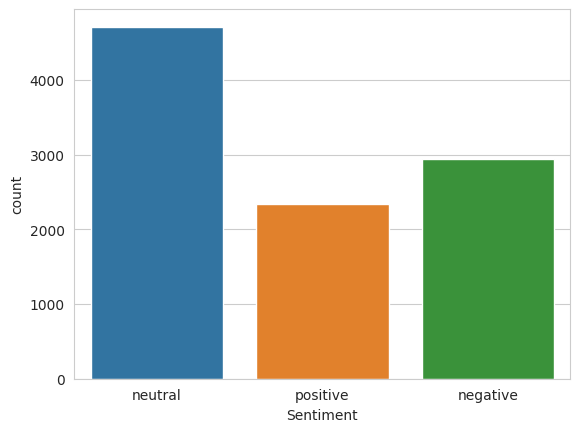

In [5]:
sns.set_style('whitegrid')
sns.countplot(x=df_train.Sentiment)

In [6]:
df_train.Speaker.value_counts()

Joey                1510
Ross                1458
Rachel              1435
Phoebe              1321
Monica              1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64

In [7]:
df_train=df_train[['Utterance','Emotion','Speaker','Sentiment']]
df_train['Utterance'] =df_train['Utterance'] + ' ' + df_train['Speaker'] + ' ' + df_train['Emotion']

<ipython-input-7-35a3bd7c5227>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Utterance'] =df_train['Utterance'] + ' ' + df_train['Speaker'] + ' ' + df_train['Emotion']


<Axes: xlabel='Emotion', ylabel='count'>

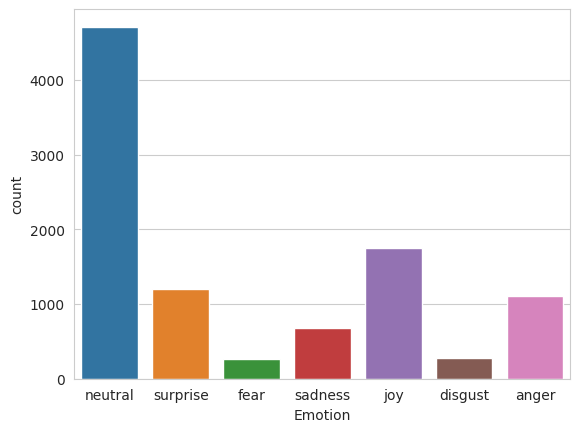

In [8]:
sns.set_style('whitegrid')
sns.countplot(x=df_train.Emotion)	

In [9]:
one_hot=pd.get_dummies(df_train[['Sentiment']])
df_train.drop(['Sentiment'],axis=1,inplace=True)
df2=pd.concat([df_train,one_hot],axis=1)
df2.head()

,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,0
1,You must’ve had your hands full. The Interview...,neutral,The Interviewer,0,1,0
2,That I did. That I did. Chandler neutral,neutral,Chandler,0,1,0
3,So let’s talk a little bit about your duties. ...,neutral,The Interviewer,0,1,0
4,My duties? All right. Chandler surprise,surprise,Chandler,0,0,1


In [10]:
def get_text_processing(text):
  stpword = stopwords.words('english')
  no_ponctuation = [char for char in text if char not in  string.punctuation]
  no_ponctuation = ''.join(no_ponctuation)
  return ' '.join([word for word in no_ponctuation.split() if word.lower() not in stpword])
from nltk.stem import PorterStemmer

def stem_words(text):
    ps = PorterStemmer()
    stemmed_words = []
    for word in text.split():
        stemmed_words.append(ps.stem(word))
    return " ".join(stemmed_words)


In [11]:
df2['review'] = df2['Utterance'].apply(get_text_processing)
df2.head()

,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive,review
0,also I was the point person on my company’s tr...,neutral,Chandler,0,1,0,also point person company’s transition KL5 GR6...
1,You must’ve had your hands full. The Interview...,neutral,The Interviewer,0,1,0,must’ve hands full Interviewer neutral
2,That I did. That I did. Chandler neutral,neutral,Chandler,0,1,0,Chandler neutral
3,So let’s talk a little bit about your duties. ...,neutral,The Interviewer,0,1,0,let’s talk little bit duties Interviewer neutral
4,My duties? All right. Chandler surprise,surprise,Chandler,0,0,1,duties right Chandler surprise


In [12]:
df2.shape

(9989, 7)

In [13]:
# supprimer les lignes où la longueur de la chaîne dans la colonne "review" est inférieure à 2
df2= df2[df2['review'].apply(lambda x: len(str(x)) >= 2)]

In [14]:
df2.shape

(9989, 7)

In [15]:
X_train=df2['review'].values
y_train=df2[['Sentiment_negative','Sentiment_neutral','Sentiment_positive']]

In [16]:
df_vald=df_vald[['Utterance','Emotion','Speaker','Sentiment']]
df_vald['Utterance'] =df_vald['Utterance'] + ' ' + df_vald['Speaker'] + ' ' + df_vald['Emotion']

<ipython-input-16-1a7b1bf81fd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vald['Utterance'] =df_vald['Utterance'] + ' ' + df_vald['Speaker'] + ' ' + df_vald['Emotion']


In [17]:
df_test=df_test[['Utterance','Emotion','Speaker','Sentiment']]
df_test['Utterance'] =df_test['Utterance'] + ' ' + df_test['Speaker'] + ' ' + df_test['Emotion']

<ipython-input-17-2a067980250b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Utterance'] =df_test['Utterance'] + ' ' + df_test['Speaker'] + ' ' + df_test['Emotion']


In [18]:
one_hot=pd.get_dummies(df_vald[['Sentiment']])
df_vald.drop(['Sentiment'],axis=1,inplace=True)
df3=pd.concat([df_vald,one_hot],axis=1)
df3.head()

,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,"Oh my God, he’s lost it. He’s totally lost it....",sadness,Phoebe,1,0,0
1,What? Monica surprise,surprise,Monica,1,0,0
2,"Or! Or, we could go to the bank, close our acc...",neutral,Ross,0,1,0
3,You’re a genius! Chandler joy,joy,Chandler,0,0,1
4,"Aww, man, now we won’t be bank buddies! Joey s...",sadness,Joey,1,0,0


In [19]:
one_hot=pd.get_dummies(df_test[['Sentiment']])
df_test.drop(['Sentiment'],axis=1,inplace=True)
df4=pd.concat([df_test,one_hot],axis=1)
df4.head()

<ipython-input-19-f4adc998138e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['Sentiment'],axis=1,inplace=True)


,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,Why do all you’re coffee mugs have numbers on ...,surprise,Mark,0,0,1
1,Oh. That’s so Monica can keep track. That way ...,anger,Rachel,1,0,0
2,Y'know what? Rachel neutral,neutral,Rachel,0,1,0
3,"Come on, Lydia, you can do it. Joey neutral",neutral,Joey,0,1,0
4,Push! Joey joy,joy,Joey,0,0,1


In [20]:
df3['review'] = df3['Utterance'].apply(get_text_processing)
df3.head()

,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive,review
0,"Oh my God, he’s lost it. He’s totally lost it....",sadness,Phoebe,1,0,0,Oh God he’s lost He’s totally lost Phoebe sadness
1,What? Monica surprise,surprise,Monica,1,0,0,Monica surprise
2,"Or! Or, we could go to the bank, close our acc...",neutral,Ross,0,1,0,could go bank close accounts cut source Ross n...
3,You’re a genius! Chandler joy,joy,Chandler,0,0,1,You’re genius Chandler joy
4,"Aww, man, now we won’t be bank buddies! Joey s...",sadness,Joey,1,0,0,Aww man won’t bank buddies Joey sadness


In [21]:
df4['review'] = df4['Utterance'].apply(get_text_processing)
df4.head()

,Utterance,Emotion,Speaker,Sentiment_negative,Sentiment_neutral,Sentiment_positive,review
0,Why do all you’re coffee mugs have numbers on ...,surprise,Mark,0,0,1,you’re coffee mugs numbers bottom Mark surprise
1,Oh. That’s so Monica can keep track. That way ...,anger,Rachel,1,0,0,Oh That’s Monica keep track way one missing li...
2,Y'know what? Rachel neutral,neutral,Rachel,0,1,0,Yknow Rachel neutral
3,"Come on, Lydia, you can do it. Joey neutral",neutral,Joey,0,1,0,Come Lydia Joey neutral
4,Push! Joey joy,joy,Joey,0,0,1,Push Joey joy


In [22]:
df3= df3[df3['review'].apply(lambda x: len(str(x)) >= 2)]
df4= df4[df4['review'].apply(lambda x: len(str(x)) >= 2)]

In [23]:
X_Val=df3['review'].values
y_val=df3[['Sentiment_negative','Sentiment_neutral','Sentiment_positive']]

In [24]:
X_test=df4['review'].values
y_test=df4[['Sentiment_negative','Sentiment_neutral','Sentiment_positive']]

In [25]:
vect=CountVectorizer()
X_train=vect.fit_transform(X_train)
X_val=vect.transform(X_Val)
X_test=vect.transform(X_test)

In [26]:
tfid = TfidfTransformer()

X_train = tfid.fit_transform(X_train)
X_val = tfid.fit_transform(X_val)
X_test = tfid.fit_transform(X_test)

X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

In [27]:
X_train.shape

(9989, 5743)

In [28]:
model = Sequential()
# model.add(Embedding())
model.add(Dense(units=12673, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=4000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=500, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

In [29]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=256,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
40/40 [==============================] - 13s 88ms/step - loss: 0.3121 - accuracy: 0.8598 - val_loss: 0.1154 - val_accuracy: 0.9423
Epoch 2/10
40/40 [==============================] - 3s 63ms/step - loss: 0.0568 - accuracy: 0.9738 - val_loss: 0.1439 - val_accuracy: 0.9360
Epoch 3/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0341 - accuracy: 0.9851 - val_loss: 0.1562 - val_accuracy: 0.9396
Epoch 4/10
40/40 [==============================] - 2s 59ms/step - loss: 0.0284 - accuracy: 0.9870 - val_loss: 0.1391 - val_accuracy: 0.9423
Epoch 5/10
40/40 [==============================] - 2s 57ms/step - loss: 0.0236 - accuracy: 0.9895 - val_loss: 0.1786 - val_accuracy: 0.9432
Epoch 6/10
40/40 [==============================] - 2s 56ms/step - loss: 0.0226 - accuracy: 0.9893 - val_loss: 0.2197 - val_accuracy: 0.9369
Epoch 7/10
40/40 [==============================] - 2s 56ms/step - loss: 0.0234 - accuracy: 0.9886 - val_loss: 0.1353 - val_accuracy: 0.9441
Epoch 8/10
4

In [31]:
model_score=model.evaluate(X_test,y_test,batch_size=64,verbose=1)
print('Test accuracy:',model_score[1])

41/41 [==============================] - 0s 9ms/step - loss: 0.1687 - accuracy: 0.9510
Test accuracy: 0.9509578347206116
